### Johdanto datatieteeseen
# Tampereen kaksiot
## Tuomas Mäkäräinen, 274351

In [1]:
from bs4 import BeautifulSoup as bs
from requests import get
import pandas as pd
import numpy as np
import time, os
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


%matplotlib inline

print('Done importing')

Done importing


In [2]:
fileName = 'tampere_kaksiot_etuovi.csv'
headers = ({'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
baseUrl = 'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1481024326&sivu='
html = get(baseUrl, headers=headers)
soup = bs(html.text, 'html.parser')

In [3]:
houseCards = soup.find_all('div', class_="ListPage__cardContainer__39dKQ")
tabs = soup.find_all('button', class_="theme__button__1YqFK theme__flat__13aFK theme__button__1YqFK theme__squared__17Uvn theme__neutral__1F1Jf Button__button__3K-jn Pagination__button__3H2wX")
max_tab = int(tabs[-1].contents[0])

In [7]:

if fileName in os.listdir('./data/'):
    df = pd.read_csv(f'./data/{fileName}', index_col=0)
    print('Local data found! Imported to DataFrame.')
else:
    loadingBar = []
    limit = 0.1
    data = {
    'Alue': [],
    'Osoite': [],
    'Hinta': [],
    'Koko': [],
    'Vuosi': [],
    'Talotyyppi': [],
    'Sauna': [],
    'Parveke': [],
    }

    for i in range(max_tab):
        clear_output(wait=True)

        baseUrl = f'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1481024326&sivu={i+1}'
        html = get(baseUrl, headers=headers)
        soup = bs(html.text, 'html.parser')

        houseCards = soup.find_all('div', class_="ListPage__cardContainer__39dKQ")

        for temp in houseCards:
        #temp = houseCards[0]
            spans = temp.find_all('span', class_='')
            """ price = spans[5].contents[0].replace('\xa0', '')[:-1] # Hinta
            size = spans[7].contents[0] # Koko
            year = spans[10].contents[0] # Vuosi """

            isSize = False
            isPrice = False
            isYear = False

            for item in spans:
                if isPrice:
                    price = item.contents[0].replace('\xa0', '')[:-1]
                    price = float(price.replace(',','.'))
                    isPrice = False
                elif isSize:
                    try:
                        size = float(item.contents[0].replace(',', '.'))
                    except ValueError:
                        size = None
                    isSize = False
                elif isYear:
                    try:
                        year = int(item.contents[0])
                    except ValueError:
                        year = None
                    isYear = False
                else:

                    if 'Hinta' in item.contents and 'Hintamuutos' not in item.contents:
                        isPrice = True
                    elif 'Koko' in item.contents:
                        isSize = True
                    elif 'Vuosi' in item.contents:
                        isYear = True

            raw_address = temp.find('h4').contents[0]
            try:
                address, area, city_ = raw_address.split(', ') # Osoite, Alue
            except ValueError:
                address, city = raw_address.split(', ')
                if 'Opiskelijankatu' in address:
                    area = 'Hervanta'

            raw_type = temp.find('h5').contents[0]
            try:
                house_type, raw_attributes = raw_type.split(' | ') # Talotyyppi
                attributes = raw_attributes.split(' + ') # Ominaisuudet
            except ValueError:
                house_type = raw_type


            data['Alue'].append(area)
            data['Osoite'].append(address)
            data['Hinta'].append(price)
            data['Koko'].append(size)
            data['Vuosi'].append(year)
            data['Talotyyppi'].append(house_type)
            if 's' in attributes:
                sauna = True
            else:
                sauna = False
            if 'p' in attributes:
                balcony = True
            else:
                for item in attributes:
                    if 'parveke' in item:
                        balcony = True
                else:
                    balcony = False

            data['Sauna'].append(sauna)
            data['Parveke'].append(balcony)
        
        if i/max_tab >= limit:
            loadingBar.append('#')
            limit += 0.1
        print('{}{:10}{}'.format('|', ''.join(loadingBar), '|'))
    df = pd.DataFrame(data)
    df.to_csv('./data/tampere_kaksiot_etuovi.csv')
    print('Done scraping')

Local data found! Imported to DataFrame.


In [ ]:
df.head()

In [ ]:
df.info()

In [8]:
df = df.dropna(axis=0)
df['Hinta'] = df['Hinta'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 919 entries, 0 to 922
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Alue        919 non-null    object 
 1   Osoite      919 non-null    object 
 2   Hinta       919 non-null    int64  
 3   Koko        919 non-null    float64
 4   Vuosi       919 non-null    float64
 5   Talotyyppi  919 non-null    object 
 6   Sauna       919 non-null    bool   
 7   Parveke     919 non-null    bool   
dtypes: bool(2), float64(2), int64(1), object(3)
memory usage: 52.1+ KB


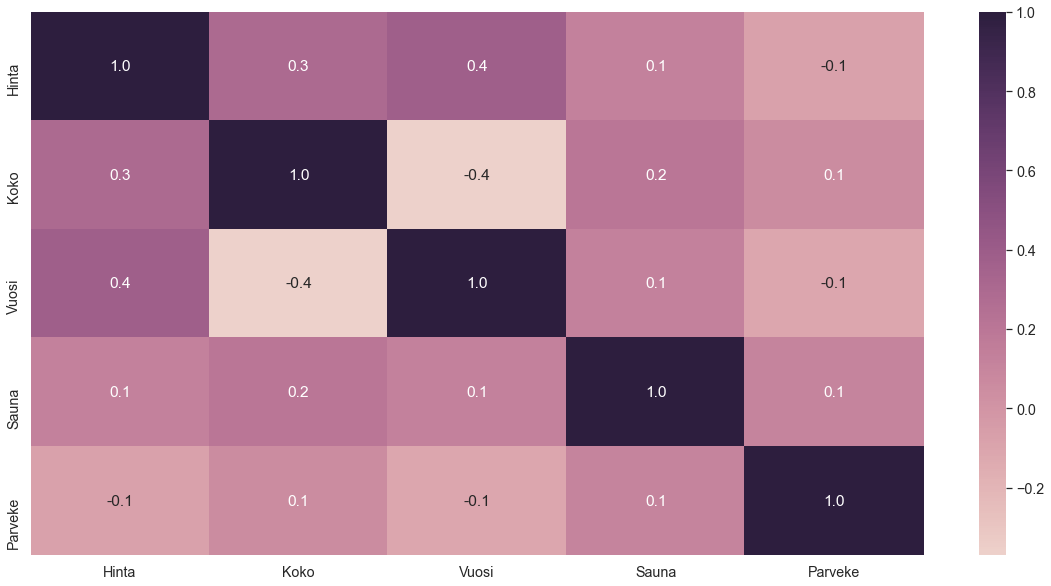

In [11]:
cmap = sb.cubehelix_palette(as_cmap=True)
color = sb.cubehelix_palette()

sb.set(font_scale=1.3)
correlation_df = df.corr()
plt.figure(figsize=(20,10))
sb.heatmap(correlation_df,annot=True,fmt='.1f',cmap=cmap)

In [ ]:
plt.figure(figsize=(20,10))
sb.distplot(df['Hinta'], color=color[5], rug=True)

In [12]:
corr_dict=correlation_df['Hinta'].sort_values(ascending=False).to_dict()
important_cols=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<0.8)) | (value<=-0.1):
        important_cols.append(key)
important_cols

['Vuosi', 'Koko', 'Sauna']

In [ ]:
plt.figure(figsize=(20,10))
sb.boxplot(x='Vuosi', y="Hinta", data=df)
sb.swarmplot(x='Vuosi', y="Hinta", data=df, color=".25")

plt.xticks(weight='bold',rotation=90)


In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.info()

In [ ]:
df.describe()

In [27]:
y = df[['Hinta']]
X = df[important_cols]
X_train, X_test, y_test, y_train = train_test_split(X, y, random_state=5)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(689, 3) (230, 3) (230, 1) (689, 1)


In [28]:
lm = LinearRegression()
lm.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [689, 230]

In [ ]:
train.interpolate(method='linear',inplace=True)
test.interpolate(method='linear',inplace=True)

In [ ]:
correlation_train=train.corr()
plt.figure(figsize=(5,20))
sb.heatmap(correlation_train[['Hinta']].sort_values(by=['Hinta'],ascending=False).head(60),vmin=-1, cmap=cmap, annot=True)

In [ ]:
plt.figure(figsize=(25,10))
train.boxplot(column=important_cols)
plt.xticks(weight='bold',rotation=90)

In [ ]:
colors=[plt.cm.tab20(each) for each in np.linspace(0, 1, len(important_cols))]
for i,c in zip(important_cols,colors):
    plt.style.use('seaborn-dark-palette')
    plt.figure(figsize=(15,10))
    #plt.scatter(x=train[i], y=train["SalePrice"],c=c,alpha=0.7)
    sb.jointplot(x=i, y="Hinta", data=train, kind="reg",color=c)
    #sb.regplot(x=train[i], y=train["SalePrice"], color=c,fit_reg=True,marker='o',scatter_kws={'s':50})
    plt.xlabel(str(i))
    plt.yticks(np.arange(0,800001,50000))

In [19]:
X

,Vuosi,Koko,Sauna
0,1970.0,55.5,False
1,2007.0,62.0,True
2,1973.0,54.5,False
3,2006.0,50.5,True
4,1984.0,46.5,True
...,...,...,...
918,2019.0,36.5,False
919,2019.0,44.0,False
920,2019.0,44.0,False
921,2019.0,39.0,False


In [20]:
y

0       96000
1      188000
2      139000
3      199000
4      105000
        ...  
918    183500
919    206500
920    199900
921    137000
922     85000
Name: Hinta, Length: 919, dtype: int64